## Librairies

In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import math

2025-10-12 07:03:00.969070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760252581.225791      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760252581.298195      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Import données & repo

In [2]:
dicom_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
train_df = pd.read_csv("/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv")

In [3]:
print(train_df.columns)

Index(['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality',
       'Left Infraclinoid Internal Carotid Artery',
       'Right Infraclinoid Internal Carotid Artery',
       'Left Supraclinoid Internal Carotid Artery',
       'Right Supraclinoid Internal Carotid Artery',
       'Left Middle Cerebral Artery', 'Right Middle Cerebral Artery',
       'Anterior Communicating Artery', 'Left Anterior Cerebral Artery',
       'Right Anterior Cerebral Artery', 'Left Posterior Communicating Artery',
       'Right Posterior Communicating Artery', 'Basilar Tip',
       'Other Posterior Circulation', 'Aneurysm Present'],
      dtype='object')


In [4]:
# Liste des colonnes correspondant aux localisations d'anévrysmes
aneurysm_cols = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation'
]

In [5]:
# Fonction pour déterminer le statut d'anévrysme par série
def determine_aneurysm(row):
    positives = [col for col in aneurysm_cols if row[col] == 1]
    if len(positives) == 0:
        return "Nothing"
    elif len(positives) == 1:
        return positives[0]
    else:
        return "Multiple"

In [6]:
# Application de la fonction à chaque ligne
label_df = train_df[['SeriesInstanceUID'] + aneurysm_cols].copy()
label_df['Aneurysm'] = label_df.apply(determine_aneurysm, axis=1)

# Sélection uniquement des colonnes intéressantes
label_df = label_df[['SeriesInstanceUID', 'Aneurysm']]

                                   SeriesInstanceUID  \
0  1.2.826.0.1.3680043.8.498.10004044428023505108...   
1  1.2.826.0.1.3680043.8.498.10004684224894397679...   
2  1.2.826.0.1.3680043.8.498.10005158603912009425...   
3  1.2.826.0.1.3680043.8.498.10009383108068795488...   
4  1.2.826.0.1.3680043.8.498.10012790035410518400...   

                      Aneurysm  
0                      Nothing  
1                      Nothing  
2  Other Posterior Circulation  
3                      Nothing  
4                      Nothing  


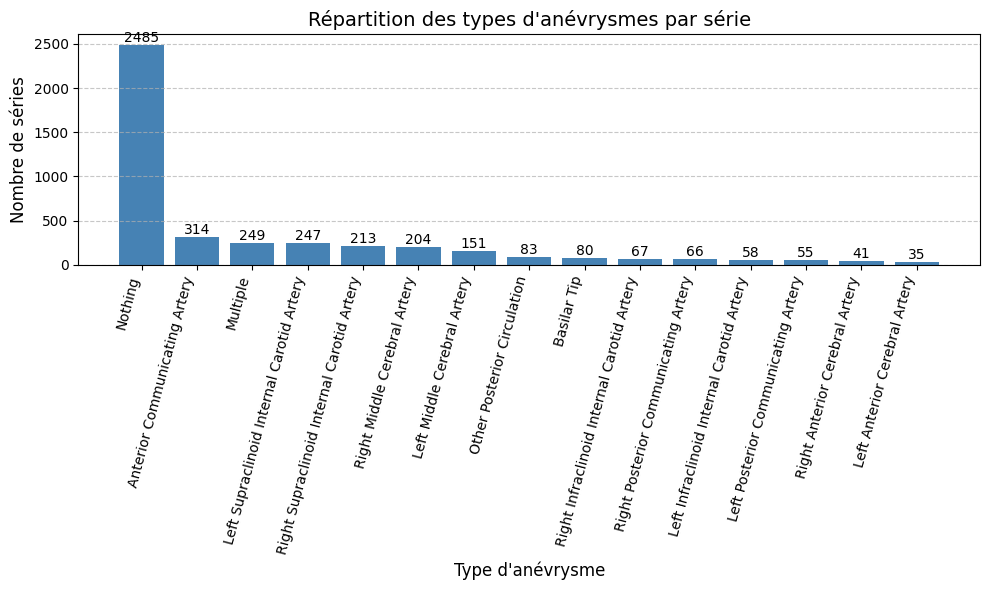

In [7]:
# Vérification du résultat
print(label_df.head())

# Comptage des occurrences de chaque valeur d'anévrysme
aneurysm_counts = label_df['Aneurysm'].value_counts().sort_values(ascending=False)

# Création du bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(aneurysm_counts.index, aneurysm_counts.values, color='steelblue')

# Personnalisation du graphique
plt.title("Répartition des types d'anévrysmes par série", fontsize=14)
plt.xlabel("Type d'anévrysme", fontsize=12)
plt.ylabel("Nombre de séries", fontsize=12)
plt.xticks(rotation=75, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# ➕ Ajout des valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # position x centrée
        height + 0.5,                       # position y légèrement au-dessus
        f'{int(height)}',                   # valeur entière
        ha='center', va='bottom', fontsize=10
    )

# Affichage
plt.tight_layout()
plt.show()


## Paramétrage

In [8]:
size_img = 256

# --- liste de techniques à combiner ---
liste_techniques = ["MIP",  "Variance", "Std", "Entropy", "Energy"]    # "Median"   "MIP"    "MinIP"    "Sum"    "AIP"   "Entropy"   "Gradient"   "Std"   "Energy"

## Fonction Projection 3D -> 2D

In [9]:
# --- Fonction de projection ---
def apply_projection(volume, technique):
    if technique == "MIP":
        return np.max(volume, axis=0)
    elif technique == "MinIP":
        return np.min(volume, axis=0)
    elif technique == "AIP":
        return np.mean(volume, axis=0)
    elif technique == "Sum":
        return np.sum(volume, axis=0)
    elif technique == "Median":
        return np.median(volume, axis=0)
    elif technique == "Variance":
        return np.var(volume, axis=0)
    elif technique == "Std":
        return np.std(volume, axis=0)
    elif technique == "Entropy":
        return -np.sum(volume * np.log(volume + 1e-8), axis=0)
    elif technique == "Gradient":
        gx, gy, gz = np.gradient(volume)
        grad_mag = np.sqrt(gx**2 + gy**2 + gz**2)
        return  np.max(grad_mag, axis=0)
    elif technique == "Energy":
        return np.sum(volume**2, axis=0)
    else:
        raise ValueError(f"Technique inconnue : {technique}")

Volume 3D lu : (188, 512, 512)


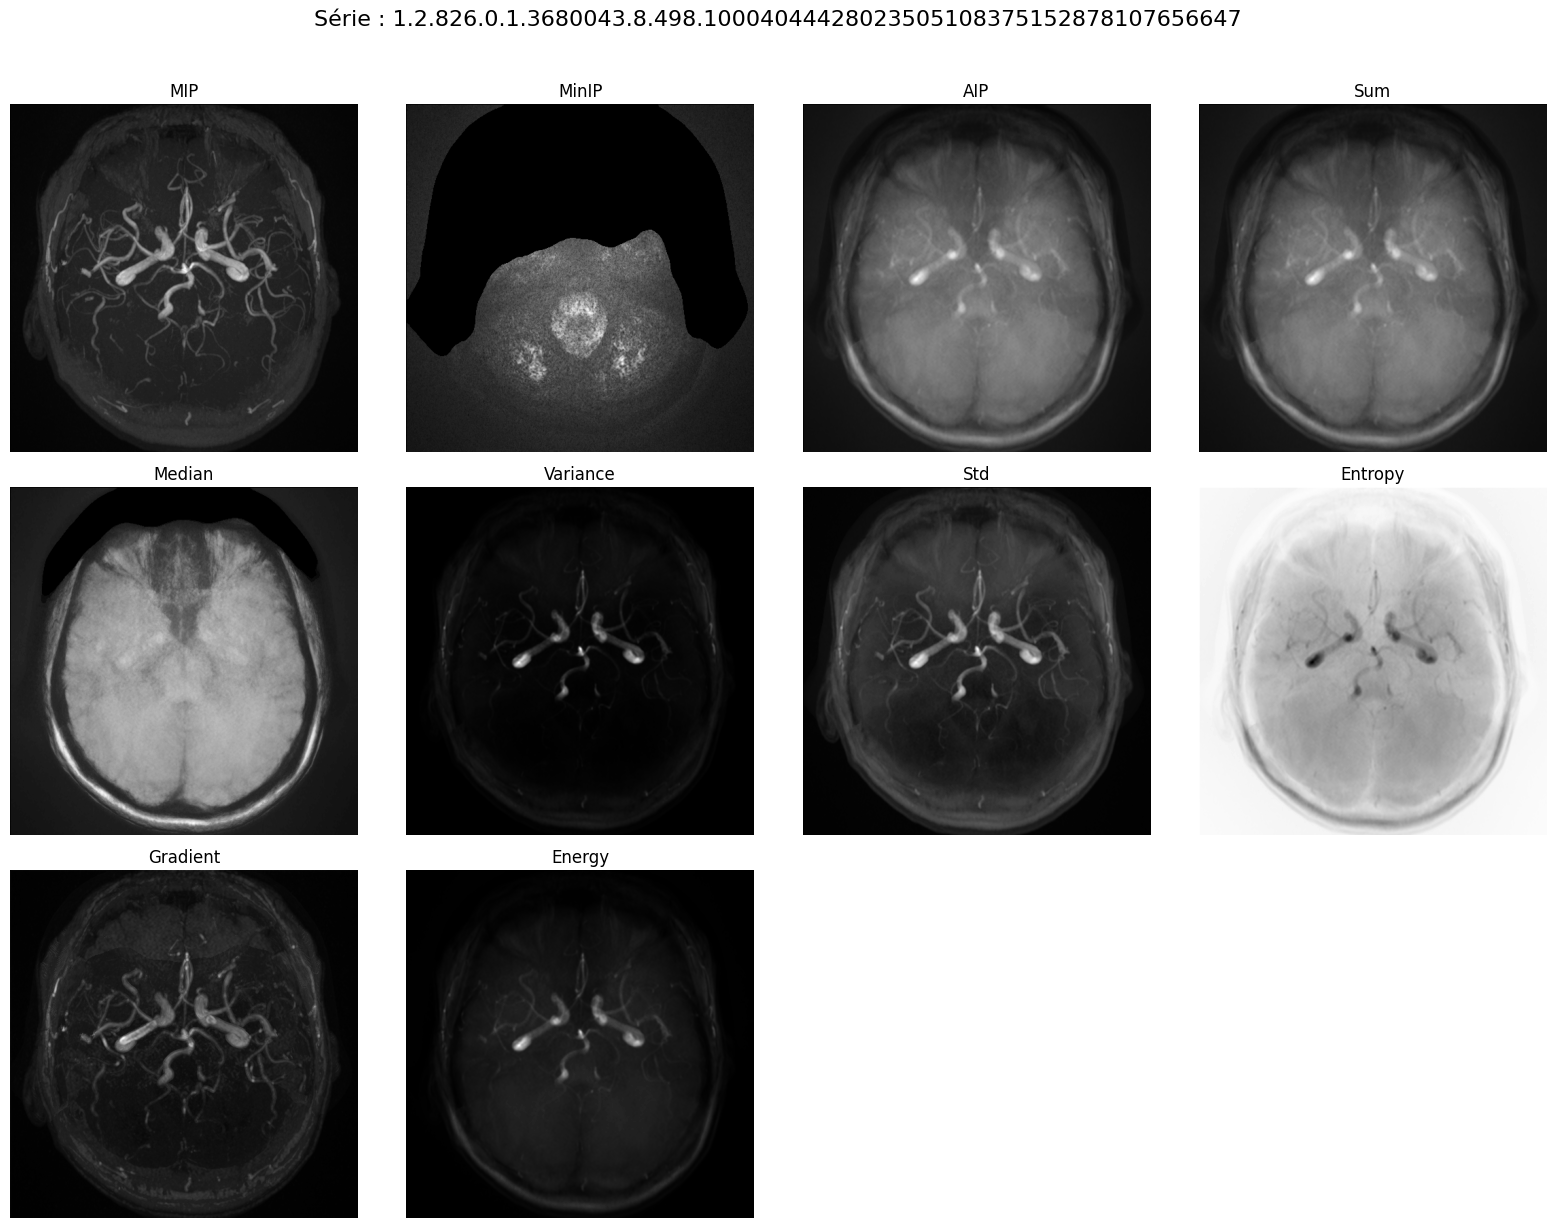

In [10]:
# Série à afficher
num_serie = 0

# --- Liste complète de techniques disponibles ---
techniques = [
    "MIP", "MinIP", "AIP", "Sum", "Median",
    "Variance", "Std", "Entropy", "Gradient", "Energy"
]

# --- Sélection d'une série pour visualisation ---
series_id = label_df.iloc[num_serie]['SeriesInstanceUID']  # première série du dataframe
series_path = os.path.join(dicom_dir, series_id)
dicom_files = sorted(os.listdir(series_path))

# Lecture des slices
series_slices = []
for filename in dicom_files:
    dcm_path = os.path.join(series_path, filename)
    try:
        ds = pydicom.dcmread(dcm_path)
        image_slice = ds.pixel_array.astype(np.float32)
        series_slices.append(image_slice)
    except Exception as e:
        print(f"Erreur lecture {filename}: {e}")
        continue

# Conversion en volume
volume = np.stack(series_slices, axis=0)
print(f"Volume 3D lu : {volume.shape}")  # (Z, H, W)

# --- Affichage des projections ---
n_cols = 4  # 4 images par ligne
n_rows = math.ceil(len(techniques) / n_cols)
plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, tech in enumerate(techniques, 1):
    try:
        img_proj = apply_projection(volume, tech)

        # Normalisation entre 0 et 1
        img_proj -= img_proj.min()
        max_val = img_proj.max()
        if max_val > 0:
            img_proj /= max_val

        # Affichage
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(img_proj, cmap='gray')
        plt.title(tech)
        plt.axis('off')

    except Exception as e:
        plt.subplot(n_rows, n_cols, i)
        plt.text(0.5, 0.5, f"Erreur\n{tech}\n{e}", ha='center', va='center')
        plt.axis('off')

plt.suptitle(f"Série : {series_id}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Data processing

In [11]:
# Réduction données 
label_df = label_df

In [12]:
label_df['SeriesInstanceUID'] = label_df['SeriesInstanceUID'].astype(str).str.strip()

In [13]:
# === Mapping texte → entier ===
unique_labels = sorted(label_df['Aneurysm'].unique())
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
print("🔤 Mapping des labels :", label_to_int)

🔤 Mapping des labels : {'Anterior Communicating Artery': 0, 'Basilar Tip': 1, 'Left Anterior Cerebral Artery': 2, 'Left Infraclinoid Internal Carotid Artery': 3, 'Left Middle Cerebral Artery': 4, 'Left Posterior Communicating Artery': 5, 'Left Supraclinoid Internal Carotid Artery': 6, 'Multiple': 7, 'Nothing': 8, 'Other Posterior Circulation': 9, 'Right Anterior Cerebral Artery': 10, 'Right Infraclinoid Internal Carotid Artery': 11, 'Right Middle Cerebral Artery': 12, 'Right Posterior Communicating Artery': 13, 'Right Supraclinoid Internal Carotid Artery': 14}


In [14]:
# Dictionnaire de conversion label -> int
# label_to_int = {"No":0, "Yes":1}  # exemple

x_images = []
y_labels = []

# Dictionnaire des séries disponibles sur disque
series_dirs_disk = {d: d for d in os.listdir(dicom_dir)}

In [15]:
# --- Boucle principale ---
for idx, row in tqdm(label_df.iterrows(), total=len(label_df), desc="Lecture des séries..."):
    series_id = row['SeriesInstanceUID']
    label_str = row['Aneurysm']

    # Vérifie la présence sur disque
    if series_id not in series_dirs_disk:
        continue

    series_path = os.path.join(dicom_dir, series_dirs_disk[series_id])
    dicom_files = sorted(os.listdir(series_path))
    if not dicom_files:
        continue

    # Lecture des slices
    series_slices = []
    for filename in dicom_files:
        dcm_path = os.path.join(series_path, filename)
        try:
            ds = pydicom.dcmread(dcm_path)
            image_slice = ds.pixel_array.astype(np.float32)
            series_slices.append(image_slice)
        except Exception as e:
            print(f"⚠️ Erreur lecture fichier {filename} (série {series_id}): {e}")
            continue

    if not series_slices:
        continue

    volume = np.stack(series_slices, axis=0)

    # --- Création de l'image multi-canaux ---
    channels = []
    for tech in liste_techniques:
        try:
            img_proj = apply_projection(volume, tech)
        except ValueError as e:
            print(e)
            continue

        # Normalisation
        img_proj -= img_proj.min()
        max_val = img_proj.max()
        if max_val > 0:
            img_proj /= max_val

        if img_proj.ndim != 2:
            continue

        channels.append(img_proj)

    if not channels:
        continue

    # Stack sur le dernier axe pour créer multi-canaux
    img_multi = np.stack(channels, axis=-1)  # (H, W, C)

    # Redimensionnement pour CNN
    img_tf = tf.expand_dims(img_multi, axis=0)  # (1, H, W, C)
    img_resized = tf.image.resize(img_tf, (size_img, size_img)).numpy()[0]

    # Stockage
    x_images.append(img_resized)
    y_labels.append(label_to_int[label_str])

Lecture des séries...:   0%|          | 2/4348 [00:06<4:00:21,  3.32s/it]/tmp/ipykernel_13/3029720413.py:18: RuntimeWarning: invalid value encountered in log
  return -np.sum(volume * np.log(volume + 1e-8), axis=0)
/tmp/ipykernel_13/3868165166.py:44: RuntimeWarning: invalid value encountered in greater
  if max_val > 0:
Lecture des séries...:  84%|████████▍ | 3659/4348 [10:00:30<1:54:33,  9.98s/it]/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(
Lecture des séries...: 100%|██████████| 4348/4348 [11:53:43<00:00,  9.85s/it]


In [16]:
# x_images est déjà multi-canaux : (N, size_img, size_img, C)
x_images = np.array(x_images, dtype=np.float32)
y_labels = np.array(y_labels, dtype=np.int64)

# One-hot encoding pour classification multiple
y_labels = to_categorical(y_labels, num_classes=len(unique_labels))

In [17]:
y_int = np.argmax(y_labels, axis=1)
pd.Series(y_int).value_counts()

8     2305
0      295
7      248
6      210
14     186
12     181
4      136
9       80
1       80
13      65
11      59
3       54
5       53
10      39
2       35
Name: count, dtype: int64

## Sauvegarde fihciers

In [18]:
# Sauvegarde dans des fichiers .npy dans le dossier de travail
np.save('/kaggle/working/x_images.npy', x_images)
np.save('/kaggle/working/y_labels.npy', y_labels)